In [9]:
import numpy as np
import numpy.linalg as la
from random import randint
import random
import re
import copy

In [10]:
class expert():
    def __init__(self, x, y, x_v, y_v, pos, action):
        self.state = (float(x), float(y), float(x_v), float(y_v), float(pos))
        self.action = float(action)
    
    def print_expert(self):    
        print("state: {} \naction: {}".format(self.state, self.action))
        return

In [11]:
def import_data(file = "expert_policy.txt"):
    expert_data = []
    with open("expert_policy.txt") as f:
        for line in f:
            temp_line = str.split(line.rstrip(), " ")
            temp_expert = expert(temp_line[0], temp_line[1], temp_line[2], temp_line[3], temp_line[4], temp_line[5])
            expert_data.append(temp_expert)
    return expert_data

In [274]:
trn_data = import_data("expert_policy.txt")

## Part 1 Environment Setup:

In [171]:
class pong_environment():
    def __init__(self):
        self.state = None
        self.reward = 0
        self.terminate = False
        

Game = pong_environment()

## Part 2.1 Deep Learning Algorithm:

- Network should produce three output scores corresponding to the three actions
- Decision based on the argmax
- Later, computing a loss function **L**
    - Softmax cross-entropy loss function (differentiable)


- Train the network using minibatch gradient-descent (loss function decreases with each iteration)

_**Minibatch gradient descent:**_

- We want to shuffle the training data at every epoch and split the data into batches. Recall that an epoch is one pass through the entire dataset. For every batch of training data, we want to perform **forward propagation** and **backward propagation** to compute the gradients of every parameter (see next section for details) and perform a gradient descent update. A batch of data is denoted by (X, y) where Xi indicates the ith state in the batch (note: Xi is a vector) and yi corresponds with the action taken by the expert at the ith state. The following figure below will make the notation more concrete.


1. Split the training data into batches (_batch size by our choice, need to justify_);
2. For every batch:

    a. Forward propagation and backward propagation to compute gradients of parameters;
    
    b. Gradient descent update;
    
_**Forwards propagation:**_

- Use weights and bias at each layer to map input to output

_**Backward propagation:**_

- Compute the gradients of the loss function at every layer

In [336]:
def as_matrix(partial_data, normalized = True):
    n = len(partial_data)
    X = np.zeros((n, 5))
    y = []
    for i in range(n):
        X[i] = partial_data[i].state
        y.append(int(partial_data[i].action))
    
    # Scaling 
    if normalized:
        for j in range(X.shape[1]):
            mean = np.mean(X[:,j])
            sd = np.var(X[:,j]) ** 1/2
            X[:,j] = (X[:,j] - mean) / sd
    
    y = np.array(y)
    return X, y    

def Affine_Forward(A, W, b):
    Z = A @ W + b
    return Z, (A, W)

def Affine_Backward(dZ, cache):
    dA = dZ @ cache[1].T
    dW = cache[0].T @ dZ
    db = np.ones(dZ.shape[0],) @ dZ
    return dA, dW, db

def Relu_Forward(Z):
    A = Z.clip(min = 0)
    return A, Z

def Relu_Backward(dA, cache):
    dZ = dA[:]
    idx = np.argwhere(cache < 0)
    for i in idx:
        dZ[tuple(i)] = 0
    return dZ

def Cross_Entropy(F, y):
    n = len(y)
    sum = 0
    
    for i in range(n):
        sum += F[i, y[i]] - np.log(np.exp(F[i]) @ np.ones((3,)))     
    L = -sum/n
    
    indicator = np.zeros((F.shape[0], F.shape[1]))
    for i in range(F.shape[0]):
        for j in range(F.shape[1]):
            if j == y[i]:
                indicator[i, j] = 1     
    fF = -1/n * (indicator - np.exp(F) / (np.exp(F) @ np.ones((3,1))))
    return L, fF

# Apply after Relu
def Dropout_Filter(A, p):
    F = np.random.binomial(1, 1-p, (A.shape[0], A.shape[1]))
    A_out = A[:]
    idx = np.argwhere(F == 0)
    for i in idx:
        A_out[tuple(i)] = 0  
    return A_out

def multi_layers_network(X, W1, W2, W3, W4, b1, b2, b3, b4, y, eta, test, drop = False):
    # Forward Propogation: four layer
    Z1, acache1 = Affine_Forward(X, W1, b1)
    A1, rcache1 = Relu_Forward(Z1)
    if drop:
        A1 = Dropout_Filter(A1, 0.2)

    Z2, acache2 = Affine_Forward(A1, W2, b2)
    A2, rcache2 = Relu_Forward(Z2)
    if drop:
        A2 = Dropout_Filter(A2, 0.2)
    
    Z3, acache3 = Affine_Forward(A2, W3, b3)
    A3, rcache3 = Relu_Forward(Z3)
    if drop:
        A3 = Dropout_Filter(A3, 0.2)
    
    F, acache4 = Affine_Forward(A3, W4, b4)
    if drop:
        F = F/(1-0.2)
    
    if test == True:
        classification = []
        for i in range(F.shape[0]):
            classification.append(np.argmax(F[i]))
        return classification
    
    # Calculating the gradients, Backward Propogation
    loss, dF = Cross_Entropy(F, y)
    dA3, dW4, db4 = Affine_Backward(dF, acache4)
    dZ3 = Relu_Backward(dA3, rcache3)
    dA2, dW3, db3 = Affine_Backward(dZ3, acache3)
    dZ2 = Relu_Backward(dA2, rcache2)
    dA1, dW2, db2 = Affine_Backward(dZ2, acache2)
    dZ1 = Relu_Backward(dA1, rcache1)
    dX, dW1, db1 = Affine_Backward(dZ1, acache1)

    # Updating the coefficents, eta can be tuned!!
    W1 = W1 - eta * dW1
    W2 = W2 - eta * dW2
    W3 = W3 - eta * dW3
    W4 = W4 - eta * dW4
    b1 = b1 - eta * db1
    b2 = b2 - eta * db2
    b3 = b3 - eta * db3
    b4 = b4 - eta * db4
    
    return loss, (W1, W2, W3, W4), (b1, b2, b3, b4)
    

def Minibatch_GD(trn_data, epoch, scaler, batch_size, normalized = True, drop = False):
    loss_plot = []
    accuracy_plot = []
    
#     W1 = scaler * np.random.rand(5, 256) 
#     W2 = scaler * np.random.rand(256, 256)
#     W3 = scaler * np.random.rand(256, 256)
#     W4 = scaler * np.random.rand(256, 3)
    
    W1 = scaler * np.random.uniform(-1, 1, (5, 256))
    W2 = scaler * np.random.uniform(-1, 1, (256, 256))
    W3 = scaler * np.random.uniform(-1, 1, (256, 256))
    W4 = scaler * np.random.uniform(-1, 1, (256,3))
    
    
    b1 = np.zeros((256,))
    b2 = np.zeros((256,))
    b3 = np.zeros((256,))
    b4 = np.zeros((3,))
    
    W = (W1, W2, W3, W4)
    b = (b1, b2, b3, b4)
    
    eta = 0.1
    
    for e in range(epoch):
        random.shuffle(trn_data)
        X_all, y_all = as_matrix(trn_data, normalized)
        loss_list = np.zeros((int(len(trn_data)/batch_size),))
        for i in range(int(len(trn_data)/batch_size)):
            X, y = as_matrix(trn_data[i*batch_size:(i+1)*batch_size], normalized)
            
            loss_list[i], W, b = multi_layers_network(X, W[0], W[1], W[2], W[3], b[0], b[1], b[2], b[3], y, eta, False, drop)
            
        pred_label = multi_layers_network(X_all, W[0], W[1], W[2], W[3], b[0], b[1], b[2], b[3], y_all, eta, True, drop)
        
        loss_plot.append(np.mean(loss_list))
        acc = accuracy(pred_label, y_all)
        accuracy_plot.append(acc)
    
        print("epoch {} finished".format(e))
        print("trn classification rate:", accuracy(pred_label, y_all))
        print("loss:", np.mean(loss_list))
        print(" ")
        
        if acc > 0.8 and eta != 0.01:
            eta = 0.01
        
#         if acc > 0.86 and e >= 200:
#             return loss_plot, accuracy_plot, W, b
        
        
        
    return loss_plot, accuracy_plot, W, b

def accuracy(prediction, actual):
    return np.mean(prediction == actual)

## _Training Start:_

In [405]:
import matplotlib.pyplot as plt

In [ ]:
epoch = 500
#scaler = 0.005
scaler = 0.05
batch_size = 200

loss_plot, accuracy_plot, W, b = Minibatch_GD(trn_data, epoch, scaler, batch_size, normalized = True, drop = False)

epoch 0 finished
trn classification rate: 0.5836
loss: 0.9632590598164711
 
epoch 1 finished
trn classification rate: 0.6518
loss: 0.8847482137156133
 
epoch 2 finished
trn classification rate: 0.6696
loss: 0.8214787587814779
 
epoch 3 finished
trn classification rate: 0.7077
loss: 0.7841478007656
 
epoch 4 finished
trn classification rate: 0.7103
loss: 0.7412338594906981
 
epoch 5 finished
trn classification rate: 0.745
loss: 0.7167163175052503
 
epoch 6 finished
trn classification rate: 0.7
loss: 0.6907492489859401
 
epoch 7 finished
trn classification rate: 0.7149
loss: 0.6871748610471949
 
epoch 8 finished
trn classification rate: 0.7492
loss: 0.6627536653900128
 
epoch 9 finished
trn classification rate: 0.7094
loss: 0.6557678441645908
 
epoch 10 finished
trn classification rate: 0.7638
loss: 0.6481957670277985
 
epoch 11 finished
trn classification rate: 0.7415
loss: 0.632698203762718
 
epoch 12 finished
trn classification rate: 0.7643
loss: 0.6180591501073033
 
epoch 13 finished

epoch 107 finished
trn classification rate: 0.8487
loss: 0.4320793021268514
 
epoch 108 finished
trn classification rate: 0.8539
loss: 0.4277085287712233
 
epoch 109 finished
trn classification rate: 0.8536
loss: 0.4139315494442364
 
epoch 110 finished
trn classification rate: 0.8492
loss: 0.43234584833755024
 
epoch 111 finished
trn classification rate: 0.848
loss: 0.44451909934219536
 
epoch 112 finished
trn classification rate: 0.8491
loss: 0.4277206013323999
 
epoch 113 finished
trn classification rate: 0.8487
loss: 0.4325383066389393
 
epoch 114 finished
trn classification rate: 0.8518
loss: 0.4298484742045828
 
epoch 115 finished
trn classification rate: 0.8559
loss: 0.42322059850902344
 
epoch 116 finished
trn classification rate: 0.8547
loss: 0.4307261029621069
 
epoch 117 finished
trn classification rate: 0.8558
loss: 0.4279572073731736
 
epoch 118 finished
trn classification rate: 0.8536
loss: 0.42321584317066546
 
epoch 119 finished
trn classification rate: 0.8552
loss: 0.42

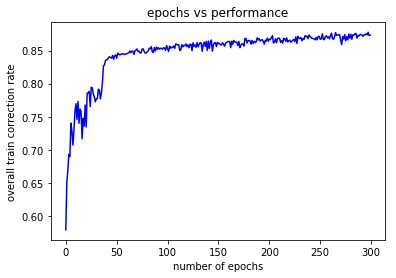

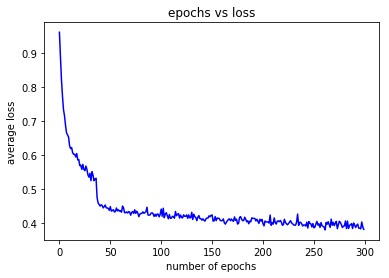

In [360]:
plt.xlabel('number of epochs')
plt.ylabel('overall train correction rate')
plt.title('epochs vs performance')
plt.plot(accuracy_plot, 'b-')
plt.show()

plt.xlabel('number of epochs')
plt.ylabel('average loss')
plt.title('epochs vs loss')
plt.plot(loss_plot, 'b-')
plt.show()

# epoch 299 finished
# trn classification rate: 0.8622
# loss: 0.40686128393571974

In [253]:
# Get confusion matrix
X_all, y_all = as_matrix(trn_data)
pred_label = multi_layers_network(X_all, W[0], W[1], W[2], W[3], b[0], b[1], b[2], b[3], y_all, None, True, drop = False)
print("Misclassification Errors:\n", 1 - accuracy(pred_label, y_all))
print(" ")
confusion_matrix = np.zeros((3,3))
for i, label in enumerate(y_all):
    if label == pred_label[i]:
        confusion_matrix[label, label] += 1
    else:
        confusion_matrix[label, pred_label[i]] += 1
sum = confusion_matrix @ np.ones((3,))
for i, row in enumerate(confusion_matrix):
    confusion_matrix[i] = row / sum[i]
    
print("Confusion Matrix:\n", confusion_matrix)

Misclassification Errors:
 0.12680000000000002
 
Confusion Matrix:
 [[0.84793041 0.0434913  0.10857828]
 [0.08194622 0.86043534 0.05761844]
 [0.05852417 0.04186907 0.89960675]]


## Part 2 Extra Credit

- Implement **batch normalization** for part 2.1. Including the forward and backwards operations. Report the number of bounces with and without batch normalization. If you are implemented.

In [334]:
epoch = 300
scaler = 0.05
batch_size = 200

# without normalization:
loss_plot, accuracy_plot, W_alt, b_alt = Minibatch_GD(trn_data, epoch, scaler, batch_size, normalized = False, drop = False)

plt.xlabel('number of epochs')
plt.ylabel('overall train correction rate')
plt.title('epochs vs performance')
plt.plot(accuracy_plot, 'b-')
plt.show()

plt.xlabel('number of epochs')
plt.ylabel('average loss')
plt.title('epochs vs loss')
plt.plot(loss_plot, 'b-')
plt.show()

epoch 0 finished
trn classification rate: 0.4323
loss: 1.0767162745464882
 
epoch 1 finished
trn classification rate: 0.4323
loss: 1.0689291609740044
 
epoch 2 finished
trn classification rate: 0.4323
loss: 1.0687873980649192
 
epoch 3 finished
trn classification rate: 0.4323
loss: 1.0685888106062713
 
epoch 4 finished
trn classification rate: 0.4323
loss: 1.0686645860814068
 
epoch 5 finished
trn classification rate: 0.4323
loss: 1.0686317881651721
 
epoch 6 finished
trn classification rate: 0.4323
loss: 1.0686039666003722
 
epoch 7 finished
trn classification rate: 0.4323
loss: 1.0685169279497393
 
epoch 8 finished
trn classification rate: 0.4323
loss: 1.0685175382522423
 
epoch 9 finished
trn classification rate: 0.4323
loss: 1.0685332111354904
 
epoch 10 finished
trn classification rate: 0.4323
loss: 1.06846394369947
 
epoch 11 finished
trn classification rate: 0.4323
loss: 1.0684752892678528
 
epoch 12 finished
trn classification rate: 0.4323
loss: 1.0683834989422458
 
epoch 13 fi

epoch 107 finished
trn classification rate: 0.6145
loss: 0.8737226225702867
 
epoch 108 finished
trn classification rate: 0.6163
loss: 0.8617421923189348
 
epoch 109 finished
trn classification rate: 0.6243
loss: 0.8797328860341882
 
epoch 110 finished
trn classification rate: 0.65
loss: 0.8728663604734989
 
epoch 111 finished
trn classification rate: 0.5445
loss: 0.8621209343813603
 
epoch 112 finished
trn classification rate: 0.6442
loss: 0.858814036750107
 
epoch 113 finished
trn classification rate: 0.6601
loss: 0.854144852891583
 
epoch 114 finished
trn classification rate: 0.4792
loss: 0.8391899182642348
 
epoch 115 finished
trn classification rate: 0.6259
loss: 0.8475407607290023
 
epoch 116 finished
trn classification rate: 0.6648
loss: 0.8520955539269559
 
epoch 117 finished
trn classification rate: 0.5736
loss: 0.8484694135174853
 
epoch 118 finished
trn classification rate: 0.6766
loss: 0.831366330752801
 
epoch 119 finished
trn classification rate: 0.6599
loss: 0.8412017540

epoch 213 finished
trn classification rate: 0.7396
loss: 0.6459639543348369
 
epoch 214 finished
trn classification rate: 0.744
loss: 0.6461646686754282
 
epoch 215 finished
trn classification rate: 0.7394
loss: 0.6453008991391127
 
epoch 216 finished
trn classification rate: 0.7392
loss: 0.6447317931638552
 
epoch 217 finished
trn classification rate: 0.7412
loss: 0.6438880124786671
 
epoch 218 finished
trn classification rate: 0.7411
loss: 0.6436080758810419
 
epoch 219 finished
trn classification rate: 0.7394
loss: 0.6426357432714761
 
epoch 220 finished
trn classification rate: 0.7377
loss: 0.6427719109794947
 
epoch 221 finished
trn classification rate: 0.743
loss: 0.6417496821358719
 
epoch 222 finished
trn classification rate: 0.7456
loss: 0.6421837345443001
 
epoch 223 finished
trn classification rate: 0.7423
loss: 0.6417098473975317
 
epoch 224 finished
trn classification rate: 0.7456
loss: 0.6405663955165376
 
epoch 225 finished
trn classification rate: 0.7394
loss: 0.6397688

KeyboardInterrupt: 

- Implement either **dropout** or any regularization scheme and split the data into 80%-20% train-validation split for part 2.1. Show the **training and validation curves on the same plot with and without regularization**, and report the best hyperparameters you achieved.


In [181]:
# Test-split-train 0.2/0.8
idx = np.random.binomial(1, 0.8, 10000)
train = []
test = []

for i, value in enumerate(idx):
    if value:
        train.append(trn_data[i])
    else:
        test.append(trn_data[i])

In [187]:
def Minibatch_GD_extra(trn_data, tst_data, epoch, scaler, batch_size, normalized = True, drop = False):
    accuracy_plot_trn = []
    accuracy_plot_tst = []   
    W1 = scaler * np.random.uniform(-1, 1, (5, 256))
    W2 = scaler * np.random.uniform(-1, 1, (256, 256))
    W3 = scaler * np.random.uniform(-1, 1, (256, 256))
    W4 = scaler * np.random.uniform(-1, 1, (256,3))
    b1 = b2 = b3 = np.zeros((256,))
    b4 = np.zeros((3,))
    W = (W1, W2, W3, W4)
    b = (b1, b2, b3, b4)
    eta = 0.1
    X_trn, y_trn = as_matrix(trn_data, normalized)
    X_tst, y_tst = as_matrix(tst_data, normalized)
    for e in range(epoch):
        random.shuffle(trn_data)
        loss_list = np.zeros((int(len(trn_data)/batch_size),))
        for i in range(int(len(trn_data)/batch_size)):
            X, y = as_matrix(trn_data[i*batch_size:(i+1)*batch_size], normalized)
            
            loss_list[i], W, b = multi_layers_network(X, W[0], W[1], W[2], W[3], b[0], b[1], b[2], b[3], y, eta, False, drop)
            
        pred_trn = multi_layers_network(X_trn, W[0], W[1], W[2], W[3], b[0], b[1], b[2], b[3], y_trn, eta, True, drop)
        pred_tst = multi_layers_network(X_tst, W[0], W[1], W[2], W[3], b[0], b[1], b[2], b[3], y_tst, eta, True, drop)
                
        acc_trn = accuracy(pred_trn, y_trn)
        acc_tst = accuracy(pred_tst, y_tst)
        accuracy_plot_trn.append(acc_trn)
        accuracy_plot_tst.append(acc_tst)
        
        print("epoch {} finished".format(e))
        print("trn classification rate:", acc_trn)
        print("tst classification rate::", acc_tst)
        print(" ")
        
        if acc_trn > 0.78 and eta != 0.01:
            eta = 0.01
            
        if acc_trn > 0.86:
            return accuracy_plot_trn, accuracy_plot_tst, W, b
      
    return accuracy_plot_trn, accuracy_plot_tst, W, b

epoch 0 finished
trn classification rate: 0.5723825122842384
tst classification rate:: 0.5777993213766359
 
epoch 1 finished
trn classification rate: 0.5929192390071816
tst classification rate:: 0.5957343674260785
 
epoch 2 finished
trn classification rate: 0.6222754189240267
tst classification rate:: 0.624818225884634
 
epoch 3 finished
trn classification rate: 0.6465919113014993
tst classification rate:: 0.6558410082404266
 
epoch 4 finished
trn classification rate: 0.640040317500315
tst classification rate:: 0.635967038293747
 
epoch 5 finished
trn classification rate: 0.670152450548066
tst classification rate:: 0.6815317498788173
 
epoch 6 finished
trn classification rate: 0.6775859896686406
tst classification rate:: 0.696073679108095
 
epoch 7 finished
trn classification rate: 0.6716643568098778
tst classification rate:: 0.6708676684440136
 
epoch 8 finished
trn classification rate: 0.6957288648103818
tst classification rate:: 0.6994667959282598
 
epoch 9 finished
trn classificati

epoch 76 finished
trn classification rate: 0.7718281466549074
tst classification rate:: 0.7576345128453709
 
epoch 77 finished
trn classification rate: 0.7674184200579564
tst classification rate:: 0.7668444013572467
 
epoch 78 finished
trn classification rate: 0.7684263575658309
tst classification rate:: 0.7668444013572467
 
epoch 79 finished
trn classification rate: 0.7688043341312839
tst classification rate:: 0.7760542898691226
 
epoch 80 finished
trn classification rate: 0.7733400529167191
tst classification rate:: 0.7712069801260301
 
epoch 81 finished
trn classification rate: 0.7637646465919113
tst classification rate:: 0.7678138633058652
 
epoch 82 finished
trn classification rate: 0.760866826256772
tst classification rate:: 0.7566650508967523
 
epoch 83 finished
trn classification rate: 0.7626307168955525
tst classification rate:: 0.7619970916141542
 
epoch 84 finished
trn classification rate: 0.7698122716391583
tst classification rate:: 0.7779932137663597
 
epoch 85 finished
tr

epoch 151 finished
trn classification rate: 0.7802696232833565
tst classification rate:: 0.7658749394086282
 
epoch 152 finished
trn classification rate: 0.7807735920372937
tst classification rate:: 0.7750848279205041
 
epoch 153 finished
trn classification rate: 0.7836714123724329
tst classification rate:: 0.782355792535143
 
epoch 154 finished
trn classification rate: 0.7776237873251859
tst classification rate:: 0.7804168686379059
 
epoch 155 finished
trn classification rate: 0.7866952248960565
tst classification rate:: 0.7833252544837616
 
epoch 156 finished
trn classification rate: 0.773718029482172
tst classification rate:: 0.7581192438196801
 
epoch 157 finished
trn classification rate: 0.78329343580698
tst classification rate:: 0.7901114881240912
 
epoch 158 finished
trn classification rate: 0.7883331233463525
tst classification rate:: 0.7726611730489579
 
epoch 159 finished
trn classification rate: 0.7774977951367015
tst classification rate:: 0.767329132331556
 
epoch 160 finis

epoch 226 finished
trn classification rate: 0.7903489983621016
tst classification rate:: 0.7770237518177412
 
epoch 227 finished
trn classification rate: 0.7969005921632859
tst classification rate:: 0.7915656810470189
 
epoch 228 finished
trn classification rate: 0.7908529671160388
tst classification rate:: 0.782355792535143
 
epoch 229 finished
trn classification rate: 0.7887110999118054
tst classification rate:: 0.7697527872031023
 
epoch 230 finished
trn classification rate: 0.7870732014615094
tst classification rate:: 0.7770237518177412
 
epoch 231 finished
trn classification rate: 0.7844273655033388
tst classification rate:: 0.7784779447406689
 
epoch 232 finished
trn classification rate: 0.7875771702154466
tst classification rate:: 0.78429471643238
 
epoch 233 finished
trn classification rate: 0.7855612951996976
tst classification rate:: 0.7678138633058652
 
epoch 234 finished
trn classification rate: 0.7893410608542271
tst classification rate:: 0.7610276296655356
 
epoch 235 fin

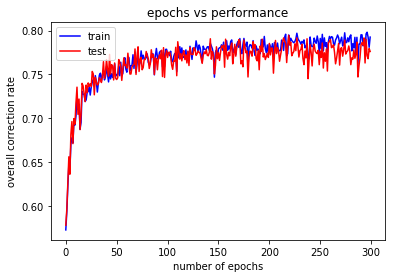

In [188]:
epoch = 300
scaler = 0.05
batch_size = 200
accuracy_trn, accuracy_tst, W_t, b_t = Minibatch_GD_extra(train, test, epoch, scaler, batch_size, normalized = True, drop = True)

plt.xlabel('number of epochs')
plt.ylabel('overall correction rate')
plt.title('epochs vs performance')
plt.plot(accuracy_trn, 'b-', label = "train")
plt.plot(accuracy_tst, 'r-', label = "test")
plt.legend(loc=2)
plt.show()

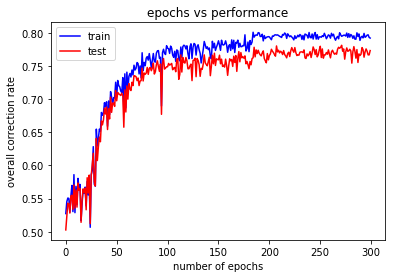

In [145]:
epoch = 300
scaler = 0.05
batch_size = 200
accuracy_trn, accuracy_tst, W_t, b_t = Minibatch_GD_extra(train, test, epoch, scaler, batch_size, normalized = True, drop = False)

plt.xlabel('number of epochs')
plt.ylabel('overall correction rate')
plt.title('epochs vs performance')
plt.plot(accuracy_trn, 'b-', label = "train")
plt.plot(accuracy_tst, 'r-', label = "test")
plt.legend(loc=2)
plt.show()

### Testing Number of bounces

In [289]:
def test_multi_layers_network(X, W1, W2, W3, W4, b1, b2, b3, b4):
    # Forward Propogation: four layer
    Z1, acache1 = Affine_Forward(X, W1, b1)
    A1, rcache1 = Relu_Forward(Z1)

    Z2, acache2 = Affine_Forward(A1, W2, b2)
    A2, rcache2 = Relu_Forward(Z2)

    
    Z3, acache3 = Affine_Forward(A2, W3, b3)
    A3, rcache3 = Relu_Forward(Z3)
 
    F, acache4 = Affine_Forward(A3, W4, b4)
    
    return np.argmax(F)
    

In [404]:
class pong_environment():
    def __init__(self):
        self.ball_x = 0.5
        self.ball_y = 0.5
        self.velocity_x = 0.03
        self.velocity_y = 0.01
        self.paddle_y = 0.5 - 0.2/2 # paddle_height: 0.2 
        self.reward = 0  
        
    def check_bounce(self, ball_x, ball_y, velocity_x, paddle_y):
        if ball_x + velocity_x < 1 or velocity_x < 0:
            return False
        
        if ball_y >= paddle_y and ball_y <= (paddle_y + 0.2):
            return True
        else:
            return False


n = 200
total_bounce = np.zeros((n,))
# Start testing Games
for i in range(n): 
    #print("Game {}".format(i))

    Game = pong_environment()
    terminate = False
    
    
    while not terminate:
        ball_x = Game.ball_x
        ball_y = Game.ball_y
        velocity_x = Game.velocity_x
        velocity_y = Game.velocity_y
        paddle_y = Game.paddle_y
        
        #print("pos:", ("%.3f"%ball_x, "%.3f"%ball_y), "v:", "%.3f"%velocity_x, "paddle range:", ("%.3f"%paddle_y, "%.3f"%(paddle_y+0.2)))
        
        
        ball_x = ball_x + velocity_x
        ball_y = ball_y + velocity_y

        # Action based on currect state
#         t = trn_data[:]
#         t.append(expert(ball_x, ball_y, velocity_x, velocity_y, paddle_y, 4))
#         X_temp, y_temp = as_matrix(t)
#         X = X_temp[-1]

        
    
        #action = test_multi_layers_network(X, W[0], W[1], W[2], W[3], b[0], b[1], b[2], b[3])

        X = np.array([ball_x, ball_y, velocity_x, velocity_y, paddle_y])
        action = test_multi_layers_network(X, W_alt[0], W_alt[1], W_alt[2], W_alt[3], b_alt[0], b_alt[1], b_alt[2], b_alt[3])
   
        if action == 0:
            paddle_y -= 0.04
        elif action == 1:
            paddle_y = paddle_y
        else:
            paddle_y += 0.04
        
        if paddle_y < 0:
            paddle_y = 0
        if paddle_y > 0.8:
            paddle_y = 0.8
        
        #print((ball_x, ball_y), (paddle_y, paddle_y+0.2))
        # Check if there is bounce
        bounce = Game.check_bounce(ball_x, ball_y, velocity_x, paddle_y)
         
        # Update 
        if not bounce: 
            # If ball pass the paddle:
            if ball_x > 1 and velocity_x > 0:
                terminate = True
            
            elif ball_y < 0:
                Game.ball_y = - ball_y
                Game.ball_x = ball_x
                Game.velocity_y = - velocity_y
                Game.paddle_y = paddle_y
                
            elif ball_y > 1:
                Game.ball_x = ball_x
                Game.ball_y = 2 - ball_y
                Game.velocity_y = - velocity_y
                Game.paddle_y = paddle_y
            
            elif ball_x < 0:
                Game.ball_x = - ball_x
                Game.ball_y = ball_y
                Game.velocity_x = - velocity_x
                Game.paddle_y = paddle_y
                
            else:
                Game.ball_x = ball_x
                Game.ball_y = ball_y
                Game.paddle_y = paddle_y
                
        else:
            #print("bounce!")
#             print((ball_x, ball_y), (paddle_y, paddle_y+0.2))
      
            total_bounce[i] += 1
            Game.ball_x = 2 - ball_x
            
            U = np.random.uniform(-0.015, 0.015)
            V = np.random.uniform(-0.03, 0.03)
            Game.velocity_x = -velocity_x + U
            Game.velocity_y = velocity_y + V
            
            while abs(Game.velocity_x) <= 0.03 or abs(Game.velocity_x) >= 1 or abs(Game.velocity_y) >= 1:
                U = np.random.uniform(-0.015, 0.015)
                V = np.random.uniform(-0.03, 0.03)
                Game.velocity_x = -velocity_x + U
                Game.velocity_y = velocity_y + V
    
            Game.ball_y = ball_y
            Game.paddle_y = paddle_y
        
print(total_bounce)
np.mean(total_bounce)

[12.  3.  5. 18.  8.  1.  8.  4. 11. 12.  7.  8.  6.  1.  4. 10.  8. 10.
  3.  3.  3.  6.  3.  4.  4. 10.  6.  2.  5. 13.  6.  1.  5.  2. 12. 10.
  4.  5. 16.  2.  6.  1.  8. 15.  2.  4.  4.  3.  6.  1. 15. 20.  1.  4.
  4.  7.  3.  1.  6.  3.  9.  1.  1.  3.  2. 16.  5.  7.  1. 28. 11. 26.
 11. 13.  3.  4. 11. 11.  2.  4.  5.  2.  3.  1.  2. 10.  9. 17.  9.  6.
 24. 16. 11. 10. 13. 11.  9.  1.  6.  5.  9.  4. 14.  3.  4.  1. 18.  2.
  1.  1.  2.  3. 25.  7.  1.  5.  2.  2.  2.  2.  4.  1. 17. 13.  4. 10.
  6.  7.  6. 13.  4.  2.  8.  5. 14.  4.  9.  2. 13.  4. 22.  3.  1.  1.
  4. 13.  2.  2. 12.  1.  6.  8.  2.  3.  9. 12.  3.  1. 13.  1. 12.  7.
  5.  3.  6.  2. 10.  9.  1.  2.  9.  1. 15.  6. 11.  8. 14.  5. 14.  1.
  7. 26.  1.  6.  1.  4.  5.  7.  1.  6.  2.  6.  1.  3.  5.  1.  1. 10.
  1.  1.]


6.615

In [358]:
X_all, y_all = as_matrix(trn_data)

pred_label = multi_layers_network(X_all, W[0], W[1], W[2], W[3], b[0], b[1], b[2], b[3], None, None, True, drop = False)
#pred_label = multi_layers_network(X_all, W_alt[0], W_alt[1], W_alt[2], W_alt[3], b_alt[0], b_alt[1], b_alt[2], b_alt[3], None, None, True, drop = False)



accuracy(pred_label, y_all)

0.8732